<a href="https://colab.research.google.com/github/gbAguiiar/machine-learning-unsupervised/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


url = 'https://raw.githubusercontent.com/gbAguiiar/machine-learning-unsupervised/refs/heads/main/mall_customers.csv'
df = pd.read_csv(url)

Visualizando informações que o dataset possui

In [26]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,64,116,33
1,2,Female,29,101,30
2,3,Male,33,36,81
3,4,Male,41,62,32
4,5,Male,36,135,42


In [27]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,2000.000000,2000.000000,2000.00000,2000.000000
mean,1000.500000,43.715500,77.44650,50.658500
std,577.494589,15.067816,35.89729,28.383687
min,1.000000,18.000000,15.00000,1.000000
25%,500.750000,31.000000,47.00000,26.000000
50%,1000.500000,43.000000,76.50000,51.000000
75%,1500.250000,56.250000,108.00000,76.000000
max,2000.000000,70.000000,140.00000,100.000000


Verificado que todas as colunas são númericas, exceto a de gênero
Será necessário aplicar o One-Hot enconding

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income (k$)      2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 78.3+ KB


dropa tabela de ID que não será relevante para o dataset

In [29]:
df = df.drop("CustomerID", axis=1)

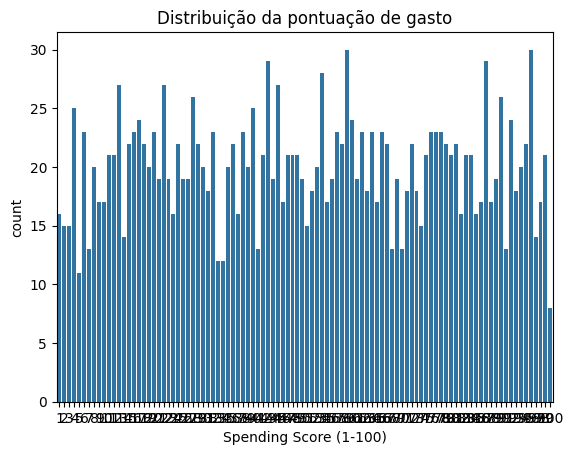

In [30]:
sns.countplot(data=df, x='Spending Score (1-100)')
plt.title("Distribuição da pontuação de gasto")
plt.show()

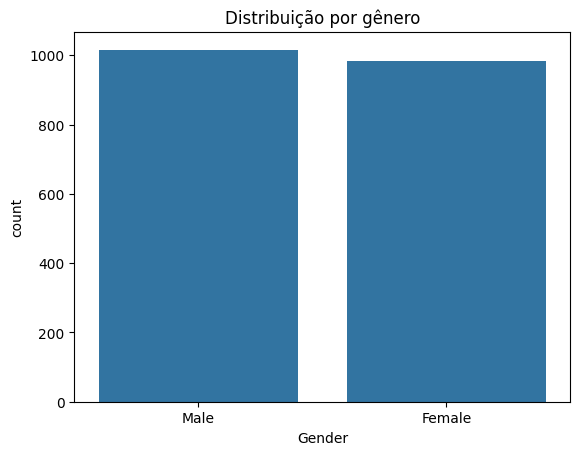

In [31]:
sns.countplot(data=df, x='Gender')
plt.title("Distribuição por gênero")
plt.show()

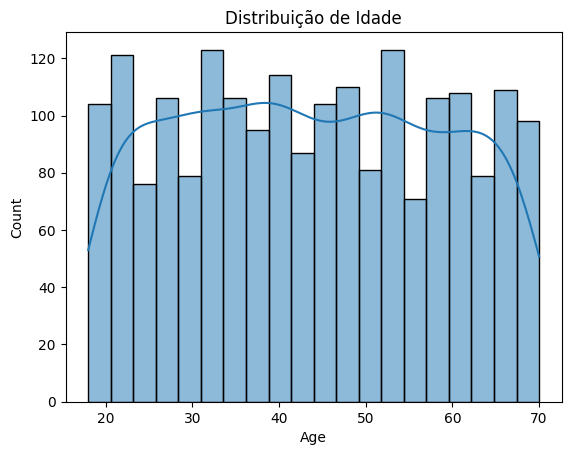

In [32]:
sns.histplot(df['Age'], bins=20, kde=True)
plt.title("Distribuição de Idade")
plt.show()


Essas diferenças de distribuição de idade já indicam que pode haver clusters naturais entre:

Jovens adultos (18–30),

Adultos médios (30–45),

Adultos mais velhos (45+).

aplica one-hot encoding na coluna Gender

In [33]:
df = pd.get_dummies(df, columns=["Gender"], drop_first=True)

Escala as colunas diretamente do dataset

In [34]:
scaler = StandardScaler()
numeric_features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
df[numeric_features] = scaler.fit_transform(df[numeric_features])

df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,1.346550,1.074263,-0.622291,True
1,-0.976862,0.656300,-0.728012,False
2,-0.711329,-1.154875,1.069244,True
3,-0.180264,-0.430405,-0.657531,True
4,-0.512180,1.603684,-0.305128,True


In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Aplica o gráfico do cotovelo para identificar o melhor número de K=4

In [36]:
X = df.copy()

inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))

Gráfico do Método do Cotovelo

Text(0, 0.5, 'Inércia (WCSS)')

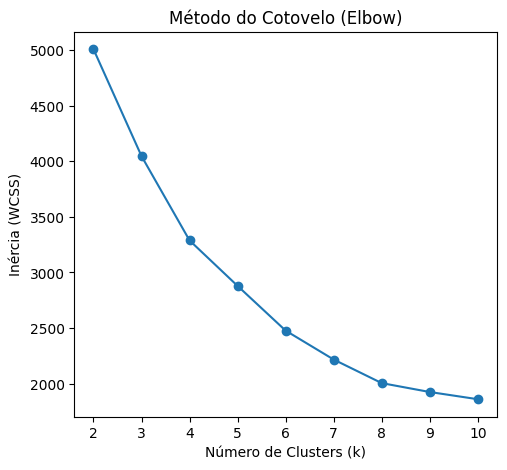

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_range, inertias, marker='o')
plt.title("Método do Cotovelo (Elbow)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inércia (WCSS)")

Através do gráfico acima usando o método do cotovelo
é perceptível que o melhor número de cluster para este dataset é K=4

In [38]:
from sklearn.cluster import KMeans

X = df[numeric_features]  # usa as colunas já escaladas
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

df['Cluster'] = clusters

In [39]:
def plot_kmeans_clusters(model: KMeans):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x="Age", y="Spending Score (1-100)", hue="Cluster", palette="viridis")
    centroids = model.cluster_centers_
    plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200, c='red', marker='X', label='Centroides'
)
    plt.title("Clusters de Clientes (K-Means)")
    plt.legend()
    plt.show()

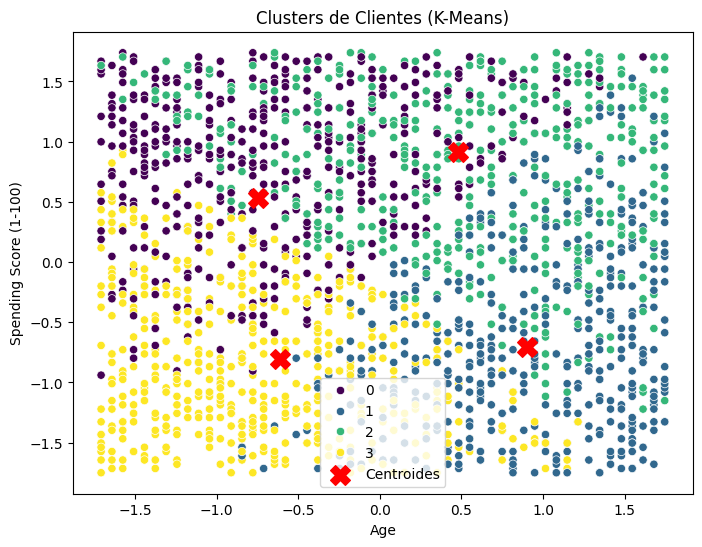

In [40]:
plot_kmeans_clusters(kmeans)

Faz um for em todas as combinações para verificar o melhor silhouette score

In [41]:
import itertools


combinacoes = [list(a) for a in itertools.combinations(numeric_features, 2)]

for combo in combinacoes:
    X = df[combo]
    _kmeans = KMeans(n_clusters=4, random_state=42)
    _labels = _kmeans.fit_predict(X)
    _score = silhouette_score(X, _labels)
    print(f"{combo} → Silhouette: {_score:.3f}")


['Age', 'Annual Income (k$)'] → Silhouette: 0.404
['Age', 'Spending Score (1-100)'] → Silhouette: 0.405
['Annual Income (k$)', 'Spending Score (1-100)'] → Silhouette: 0.405


In [42]:
df['Cluster'].value_counts()


,count
Cluster,
3,518
2,507
1,488
0,487


Apenas com as features selecionadas

In [43]:
selected_features = ['Age', 'Spending Score (1-100)']

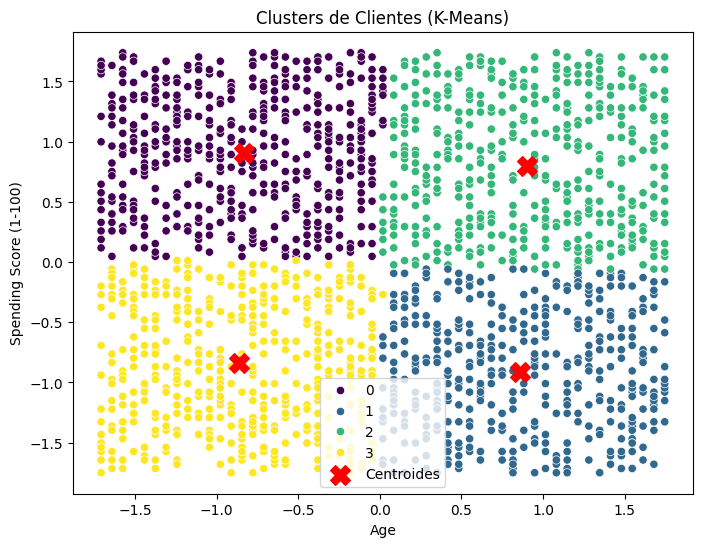

In [44]:
X = df[selected_features]
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

df['Cluster'] = clusters

plot_kmeans_clusters(kmeans)

Pelo gráfico:

Cluster roxo (0):
Clientes mais jovens (idades baixas) com alto gasto.
Esse grupo tende a ser mais impulsivo e receptivo a novidades, representando consumidores ativos e de maior engajamento.

Cluster amarelo (1):
Clientes mais jovens, porém com baixo gasto.
Podem estar em fase inicial da vida financeira ou demonstrar menor interesse em consumo — público com potencial de crescimento.

Cluster verde (2):
Clientes mais velhos, com alto gasto.
Provavelmente são consumidores mais estáveis financeiramente, que valorizam qualidade e estão dispostos a investir mais.

Cluster azul (3):
Clientes mais velhos, com baixo gasto.
Podem ser mais conservadores ou seletivos nas compras, indicando um perfil de retenção mais difícil ou de foco em produtos essenciais.

In [45]:
from sklearn.model_selection import KFold


X = df[["Age", "Spending Score (1-100)"]].values


kf = KFold(n_splits=5, shuffle=True, random_state=42)
silhouette_scores = []
db_scores = []
ch_scores = []

# Loop
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]

    # Treina o modelo K-Means
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(X_train)

    # Calcula as métricas
    sil = silhouette_score(X_train, labels)
    db = davies_bouldin_score(X_train, labels)
    ch = calinski_harabasz_score(X_train, labels)

    silhouette_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)

    print(f"Fold {fold}: Silhouette={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")
    fold += 1

sil_mean, sil_std = np.mean(silhouette_scores), np.std(silhouette_scores)
db_mean, db_std = np.mean(db_scores), np.std(db_scores)
ch_mean, ch_std = np.mean(ch_scores), np.std(ch_scores)

print("\n=== Resultados Médios (5 Folds) ===")
print(f"Silhouette Score médio: {sil_mean:.4f} ± {sil_std:.4f}")
print(f"Davies-Bouldin médio: {db_mean:.4f} ± {db_std:.4f}")
print(f"Calinski-Harabasz médio: {ch_mean:.2f} ± {ch_std:.2f}")


Fold 1: Silhouette=0.4080, DB=0.7773, CH=1597.68
Fold 2: Silhouette=0.4058, DB=0.7747, CH=1589.64
Fold 3: Silhouette=0.4008, DB=0.7828, CH=1555.67
Fold 4: Silhouette=0.4075, DB=0.7703, CH=1604.94
Fold 5: Silhouette=0.4025, DB=0.7773, CH=1569.61

=== Resultados Médios (5 Folds) ===
Silhouette Score médio: 0.4049 ± 0.0028
Davies-Bouldin médio: 0.7765 ± 0.0041
Calinski-Harabasz médio: 1583.51 ± 18.25


apresenta clusters razoavelmente definidos, mas com alguma instabilidade entre subconjuntos de dados, conforme observado na validação cruzada (Silhouette médio ≈ 0.404)

Davies-Bouldin: Uma separação moderada, com certa sobreposição entre grupos.

Ainda assim, adequado para um cenário realista de segmentação de clientes.

Calinski-Harabasz: Boa compactação e separação relativa.

Comparado com outros Ks (ex: 2, 3, 5), esse valor pode confirmar que K=4 realmente é um ponto equilibrado entre separação e coesão.

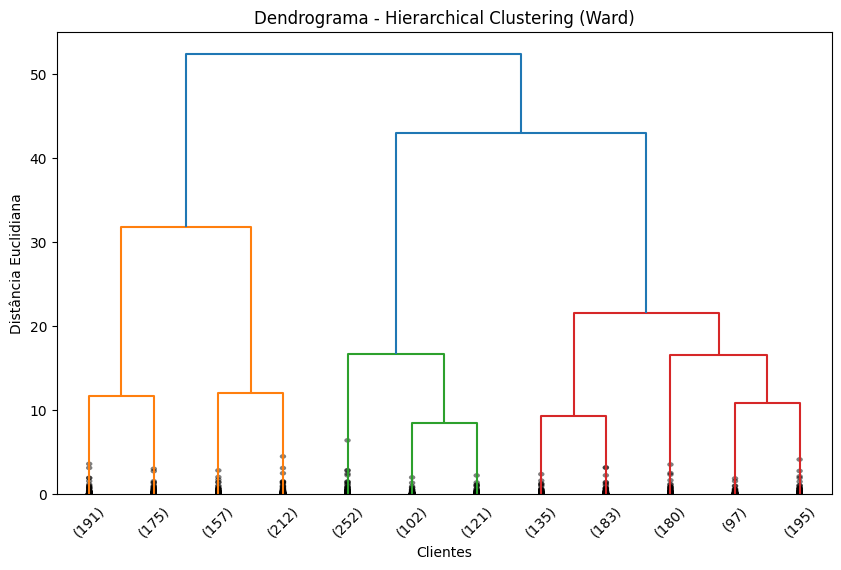

In [47]:
#APLICANDO O HIERARCHICAL CLUSTERING

X = df[["Age", "Spending Score (1-100)"]]

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criação do linkage matrix (usando método 'ward' que minimiza a variância dentro dos grupos)
Z = linkage(X_scaled, method='ward')

# Plot do dendrograma
plt.figure(figsize=(10, 6))
plt.title("Dendrograma - Hierarchical Clustering (Ward)")
plt.xlabel("Clientes")
plt.ylabel("Distância Euclidiana")
dendrogram(Z, truncate_mode="lastp", p=12, leaf_rotation=45, leaf_font_size=10, show_contracted=True)
plt.show()


O dendrograma mostra quatro agrupamentos bem separados, reforçando que o corte foi adequado.

As distâncias maiores entre os grupos (altura das linhas) indicam diferenças significativas no comportamento de consumo, especialmente entre grupos de idades e padrões de gasto diferentes.

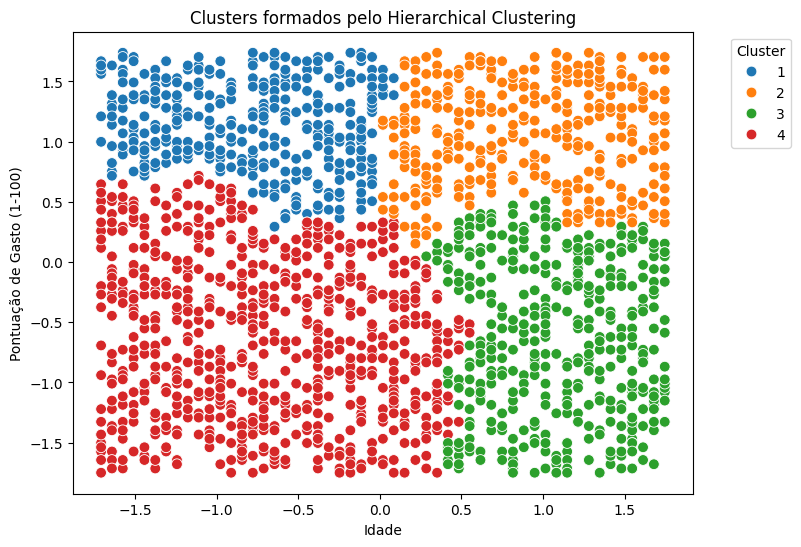

Silhouette Score: 0.3464
Davies-Bouldin Index: 0.8310
Calinski-Harabasz Index: 1555.6829


In [48]:



# Define o número de clusters
n_clusters = 4
clusters_h = fcluster(Z, n_clusters, criterion='maxclust')

# Adiciona ao DataFrame
df['Cluster_H'] = clusters_h

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df["Age"],
    y=df["Spending Score (1-100)"],
    hue=df["Cluster_H"],
    palette="tab10",
    s=60
)
plt.title("Clusters formados pelo Hierarchical Clustering")
plt.xlabel("Idade")
plt.ylabel("Pontuação de Gasto (1-100)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Avaliação de métricas
sil = silhouette_score(X_scaled, clusters_h)
db = davies_bouldin_score(X_scaled, clusters_h)
ch = calinski_harabasz_score(X_scaled, clusters_h)

print(f"Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Index: {db:.4f}")
print(f"Calinski-Harabasz Index: {ch:.4f}")


In [49]:

from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold
import numpy as np

# Cria o KFold com 5 divisões
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar métricas
sil_scores, db_scores, ch_scores = [], [], []


max_sample = 600
rng = np.random.RandomState(42)

for i, (train_idx, _) in enumerate(kf.split(X_scaled)):
    X_train = X_scaled[train_idx]

    # Limita número de amostras
    if X_train.shape[0] > max_sample:
        sel = rng.choice(X_train.shape[0], size=max_sample, replace=False)
        X_train = X_train[sel]

    # Cria e treina o modelo hierárquico
    hc = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')
    labels = hc.fit_predict(X_train)

    # Calcula métricas
    sil = silhouette_score(X_train, labels)
    db = davies_bouldin_score(X_train, labels)
    ch = calinski_harabasz_score(X_train, labels)

    sil_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)

    print(f"Fold {i+1}: Silhouette={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")

# Exibe médias e desvios
print("\n=== Resultados Médios (5 Folds) ===")
print(f"Silhouette Score médio: {np.mean(sil_scores):.4f} ± {np.std(sil_scores):.4f}")
print(f"Davies-Bouldin médio: {np.mean(db_scores):.4f} ± {np.std(db_scores):.4f}")
print(f"Calinski-Harabasz médio: {np.mean(ch_scores):.2f} ± {np.std(ch_scores):.2f}")


Fold 1: Silhouette=0.3658, DB=0.7842, CH=492.24
Fold 2: Silhouette=0.3386, DB=0.8733, CH=435.27
Fold 3: Silhouette=0.3709, DB=0.7793, CH=501.44
Fold 4: Silhouette=0.3298, DB=0.8528, CH=436.88
Fold 5: Silhouette=0.3254, DB=0.8628, CH=421.03

=== Resultados Médios (5 Folds) ===
Silhouette Score médio: 0.3461 ± 0.0187
Davies-Bouldin médio: 0.8305 ± 0.0404
Calinski-Harabasz médio: 457.37 ± 32.82


O modelo hierárquico apresentou resultados ligeiramente inferiores, com menor separação entre grupos e maior sobreposição visual nas fronteiras dos clusters, porém, os resultados de validação cruzada mostram consistência nos agrupamentos, com pequenas variações entre folds. Isso indica estabilidade no comportamento dos clusters, mesmo com pequenas divisões nos dados.



**Conclusão:**

Com base nos resultados obtidos:

O K-Means foi o modelo que melhor segmentou os dados, com maior coesão interna e melhor separação entre clusters.

O Hierarchical Clustering, apesar de apresentar resultados ligeiramente inferiores, é útil para compreender a estrutura hierárquica e as relações entre grupos.

As métricas de validação cruzada confirmam que o modelo é estável e generalizável.

A análise de idade x pontuação de gasto mostrou-se eficaz para compreender perfis de consumo e pode ser utilizada por empresas para estratégias de marketing segmentadas.

Ambos os modelos cumpriram o objetivo proposto de identificar perfis distintos de clientes.
O K-Means mostrou melhor desempenho quantitativo, enquanto o Hierarchical Clustering se destacou pela interpretabilidade e estruturação visual.